In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

s = 100           
T = 1.0            
sigma = 2           
dt = 0.005          
gamma = 0.1         
k = 1.5             
A = 140
wealth = 0
q = 0

In [2]:
import numpy as np

def simulate_market_making(S0, sigma, gamma, T, dt, A, k, num_paths, strategy_type="inventory"):
    N = int(T / dt)

    def indifference_price(s, q, t):
        return s - q * gamma * sigma**2 * (T - t)

    def optimal_spread(t):
        return gamma * sigma**2 * (T - t) + (2 / gamma) * np.log(1 + gamma / k)

    def bid_ask_quotes_inventory(s, q, t):
        r = indifference_price(s, q, t)
        spread = optimal_spread(t)
        return r - spread/2, r + spread/2, r

    def bid_ask_quotes_symmetric(s, t):
        spread = optimal_spread(t)
        return s - spread/2, s + spread/2, s

    def order_probability(delta):
        return A * np.exp(-k * delta) * dt

   
    profits = []
    final_inventories = []

    for path in range(num_paths):
        
        mid_price = np.zeros(N + 1)
        mid_price[0] = S0
        for t in range(1, N + 1):
            mid_price[t] = mid_price[t - 1] + sigma * np.sqrt(dt) * np.random.randn()

        
        inventory = 0
        wealth = 0.0

        
        for t in range(N):
            s_t = mid_price[t]
            time = t * dt

            if strategy_type == "inventory":
                p_b, p_a, _ = bid_ask_quotes_inventory(s_t, inventory, time)
            elif strategy_type == "symmetric":
                p_b, p_a, _ = bid_ask_quotes_symmetric(s_t, time)
            else:
                raise ValueError("Invalid strategy_type. Choose 'inventory' or 'symmetric'.")

            delta_b = s_t - p_b
            delta_a = p_a - s_t

            if np.random.rand() < order_probability(delta_b):
                inventory += 1
                wealth -= p_b
            if np.random.rand() < order_probability(delta_a):
                inventory -= 1
                wealth += p_a

        final_wealth = wealth + inventory * mid_price[-1]
        profits.append(final_wealth)
        final_inventories.append(inventory)

    return np.mean(profits), np.mean(final_inventories)



In [3]:
import numpy as np

def simulate_market_making(S0, sigma, gamma, T, dt, A, k, num_paths, strategy_type="inventory"):
    N = int(T / dt)

    def indifference_price(s, q, t):
        return s - q * gamma * sigma**2 * (T - t)

    def optimal_spread(t):
        return gamma * sigma**2 * (T - t) + (2 / gamma) * np.log(1 + gamma / k)

    def bid_ask_quotes_inventory(s, q, t):
        r = indifference_price(s, q, t)
        spread = optimal_spread(t)
        return r - spread/2, r + spread/2, r

    def bid_ask_quotes_symmetric(s, t):
        spread = optimal_spread(t)
        return s - spread/2, s + spread/2, s

    def order_probability(delta):
        return A * np.exp(-k * delta) * dt

    profits = []
    final_inventories = []
    utilities = []

    for path in range(num_paths):
        mid_price = np.zeros(N + 1)
        mid_price[0] = S0
        for t in range(1, N + 1):
            mid_price[t] = mid_price[t - 1] + sigma * np.sqrt(dt) * np.random.randn()

        inventory = 0
        wealth = 0.0

        for t in range(N):
            s_t = mid_price[t]
            time = t * dt

            if strategy_type == "inventory":
                p_b, p_a, _ = bid_ask_quotes_inventory(s_t, inventory, time)
            elif strategy_type == "symmetric":
                p_b, p_a, _ = bid_ask_quotes_symmetric(s_t, time)
            else:
                raise ValueError("Invalid strategy_type. Choose 'inventory' or 'symmetric'.")

            delta_b = s_t - p_b
            delta_a = p_a - s_t

            if np.random.rand() < order_probability(delta_b):
                inventory += 1
                wealth -= p_b
            if np.random.rand() < order_probability(delta_a):
                inventory -= 1
                wealth += p_a

        final_wealth = wealth + inventory * mid_price[-1]
        profits.append(final_wealth)
        final_inventories.append(inventory)
        utilities.append(-np.exp(-gamma * final_wealth))


    profits = np.array(profits)
    final_inventories = np.array(final_inventories)
    abs_inventories = np.abs(final_inventories)

    spread = gamma * sigma**2 * T + (2 / gamma) * np.log(1 + gamma / k)
    avg_pnl = profits.mean()
    std_pnl = profits.std()
    avg_abs_inventory = abs_inventories.mean()
    std_abs_inventory = abs_inventories.std()
    sharpe_ratio = avg_pnl / std_pnl

    return {"gamma": gamma,
        "strategy": strategy_type,
        "spread": spread,
        "avg_pnl": avg_pnl,
        "std_pnl": std_pnl,
        "avg_abs_inventory": avg_abs_inventory,
        "std_abs_inventory": std_abs_inventory,
        "sharpe_ratio": sharpe_ratio}


In [4]:
simulate_market_making(100,2,0.1,1,0.005,140,1.5,1000,"symmetric")

{'gamma': 0.1,
 'strategy': 'symmetric',
 'spread': 1.6907704227514233,
 'avg_pnl': 68.46899868939141,
 'std_pnl': 12.5996856980863,
 'avg_abs_inventory': 6.551,
 'std_abs_inventory': 5.0389878944089554,
 'sharpe_ratio': 5.434183068534067}

In [5]:
gamma_values = np.linspace(0.1, 2, 20)
S0 = 100
results_inventory = []
results_symmetric = []

for gamma in gamma_values:
    results_inv = simulate_market_making(S0, sigma, gamma, T, dt, A, k, 1000, "inventory")
    results_sym = simulate_market_making(S0, sigma, gamma, T, dt, A, k, 1000, "symmetric")
    results_inventory.append(results_inv)
    results_symmetric.append(results_sym)

df_inventory = pd.DataFrame(results_inventory)
df_symmetric = pd.DataFrame(results_symmetric)

In [6]:
df_symmetric
df_inventory

,gamma,strategy,spread,avg_pnl,std_pnl,avg_abs_inventory,std_abs_inventory,sharpe_ratio
0,0.1,inventory,1.690770,64.535259,6.509079,2.400,1.850405,9.914652
1,0.2,inventory,2.051631,60.824291,6.124422,1.946,1.520225,9.931433
2,0.3,inventory,2.415477,56.745148,6.220412,1.753,1.332663,9.122410
3,0.4,inventory,2.781944,52.816191,5.997398,1.599,1.269724,8.806517
4,0.5,inventory,3.150728,48.595514,5.845594,1.551,1.198916,8.313187
5,0.6,inventory,3.521574,44.378111,5.693942,1.469,1.195424,7.793917
6,0.7,inventory,3.894264,40.616053,5.347578,1.344,1.112503,7.595224
7,0.8,inventory,4.268610,37.474687,5.083799,1.385,1.085714,7.371394
8,0.9,inventory,4.644453,34.225732,5.019718,1.242,1.043761,6.818258
9,1.0,inventory,5.021651,31.443638,4.761112,1.279,1.012501,6.604263


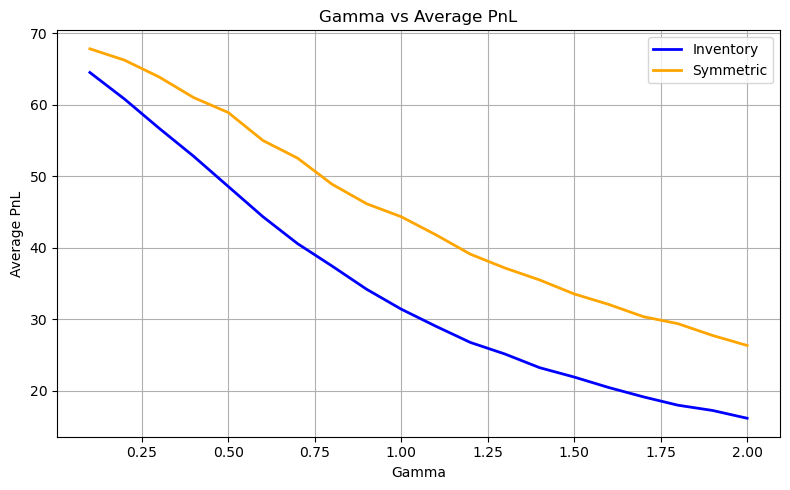

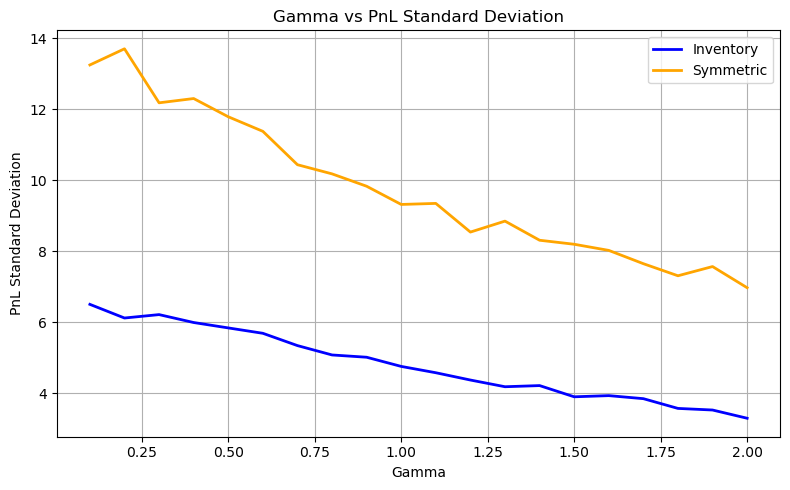

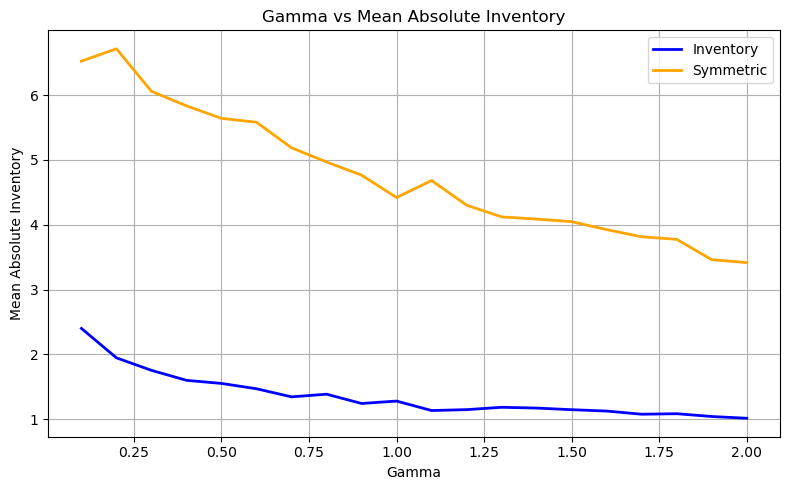

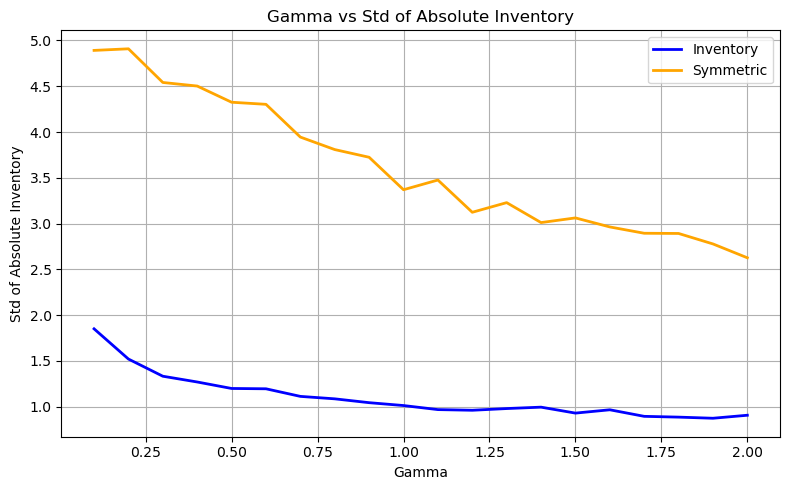

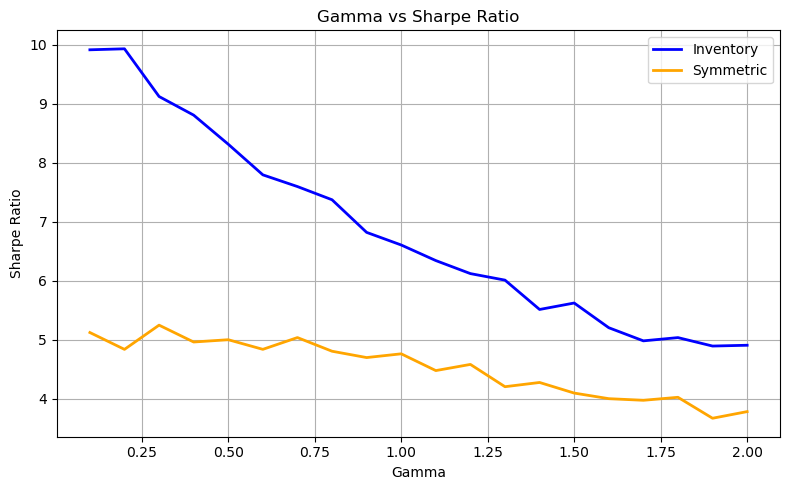

In [7]:

def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))
    plt.plot(df_inventory['gamma'], df_inventory[metric_name], label="Inventory", color='blue', linewidth=2)
    plt.plot(df_symmetric['gamma'], df_symmetric[metric_name], label="Symmetric", color='orange', linewidth=2)
    plt.xlabel("Gamma")
    plt.ylabel(ylabel)
    plt.title(f"Gamma vs {ylabel}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("avg_pnl", "Average PnL")
plot_metric("std_pnl", "PnL Standard Deviation")
plot_metric("avg_abs_inventory", "Mean Absolute Inventory")
plot_metric("std_abs_inventory", "Std of Absolute Inventory")
plot_metric("sharpe_ratio", "Sharpe Ratio")